### CLustering Result1

This is the first try of using som to cluster the Tokyo_umps. The setting will list below.This work aim to find the relationship between FAI and PAI in different cities around the world. (FAI and PAI are parameters in the weather model)

Setting:
Cluster_num = 4,
sigma=1.5,
learning_rate=.5,
neighborhood_function='gaussian',
random_seed=0

In [2]:
import sys 
sys.path.append("/home/jiang/lq/remote-sensing-landuse")

In [3]:
import os.path
#import utils.istarmap as istarmap # Patches mp with this to enable tqdm
from multiprocessing import Pool
import pickle
from functools import partial

from itertools import repeat
from glob import glob
import xml.dom.minidom
import tqdm

import pandas as pd
import numpy as np
import math
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import dask_geopandas as dgpd

import fiona
import shapely
import pyproj
from osgeo import gdal
# Modules
from utils import gml_utils
from utils import sp_utils
from utils.gml_utils import *
from minisom import MiniSom

### Tokyo PAI vs FAI

In [ ]:
data = gpd.read_feather("/gucnas2/jiang/Tokyo_shp/Y_UMP/Ult_Tokyo_ump.feather")
columns = ["AverageHeightBuilding","PlanarAreaIndex","MaximumHeight","FrontalAreaIndexMean","StandardDeviation"]
clustered_data = som_clustering(data,columns)
clustered_data

In [ ]:
plot_columns = ["AverageHeightBuilding","PlanarAreaIndex","FrontalAreaIndexMean"]
som_plot(clustered_data, plot_columns, elevation=0, azimuth=180)

In [ ]:
clustered_data.plot("cluster", legend=True, cmap="viridis", categories=[0, 1, 2, 3])
plt.show()

Regarding PAI and FAI, cluster1 tend to be the downtown area of Tokyo, and other clusters are tend to be a linear regression

### Osaka FAI vs PAI

In [4]:
data = gpd.read_feather("/gucnas2/jiang/Japan/osaka/osaka_ULT_ump.feather")
columns = ["AverageHeightBuilding","PlanarAreaIndex","MaximumHeight","FrontalAreaIndexMean","StandardDeviation"]
clustered_data = som_clustering(data,columns)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.3150905091505423


/home/jiang/.conda/envs/remote/lib/python3.10/site-packages/minisom.py:162: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')
/home/jiang/.conda/envs/remote/lib/python3.10/site-packages/minisom.py:379: UserWarning: PCA initialization inappropriate:One of the dimensions of the map is 1.
  warn(msg)


findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were foun

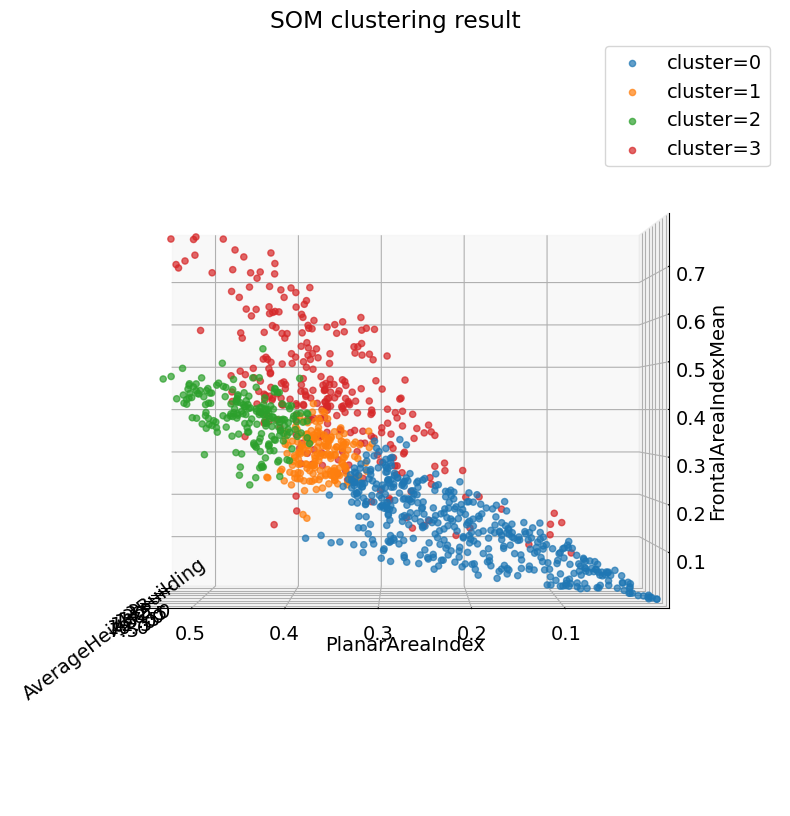

In [5]:
plot_columns = ["AverageHeightBuilding","PlanarAreaIndex","FrontalAreaIndexMean"]
som_plot(clustered_data, plot_columns, elevation=0, azimuth=180)

findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were foun

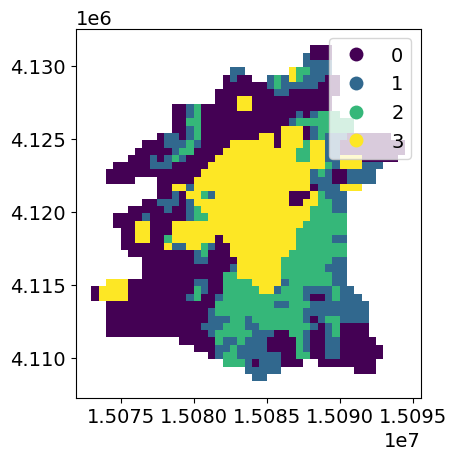

In [7]:
clustered_data.plot("cluster", legend=True, cmap="viridis", categories=[0, 1, 2,3])
plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

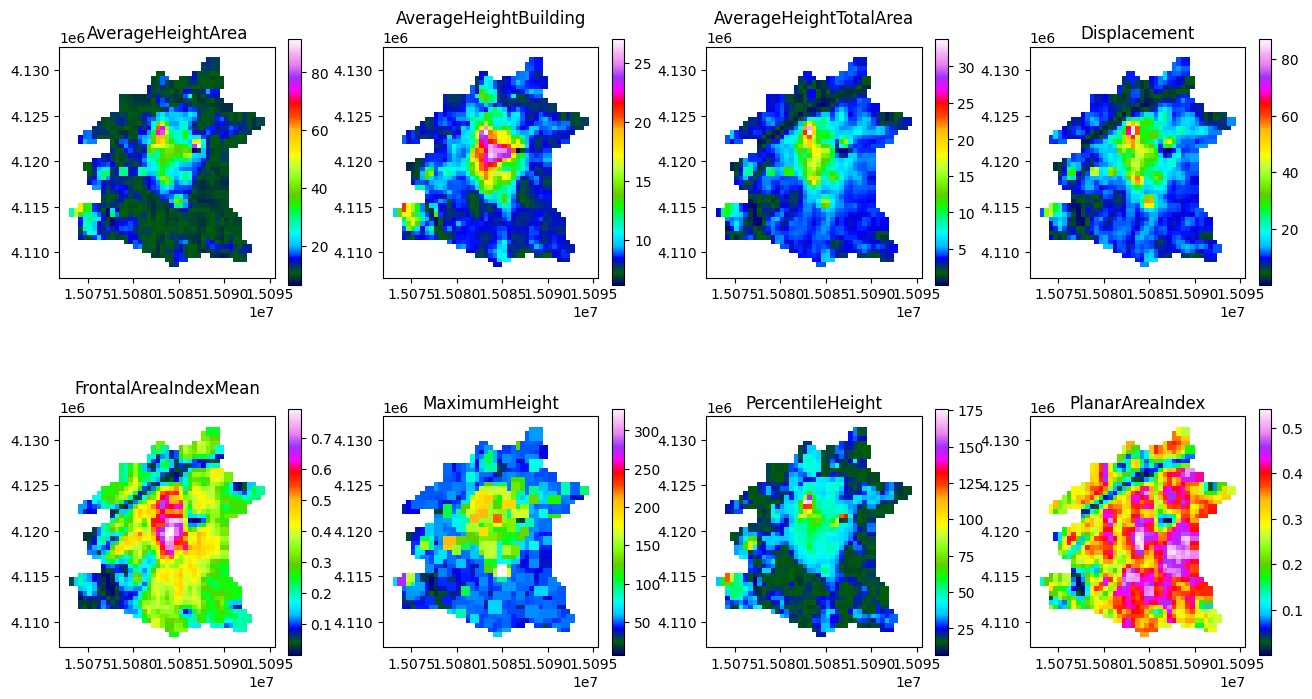

In [4]:
LA_ump = gpd.read_feather("/gucnas2/jiang/Japan/osaka/osaka_ULT_ump.feather")
# 创建一个 2x4 的子图布局
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5)

# 遍历除 'geometry' 列以外的所有列并绘制图像
columns_to_plot = LA_ump.columns.difference(['geometry', 'Percentile','FrontalAreaIndex', 'Rotation', 'RoughnessLength'])

for i, column in enumerate(columns_to_plot):
    row, col = divmod(i, 4)
    
    # 绘制当前列的图像
    LA_ump.plot(column=column, ax=axes[row, col], legend=True, cmap='gist_ncar')  # 使用适当的色彩图
    axes[row, col].set_title(column)

# 显示图像
plt.tight_layout()
plt.show()

### kyoto FAI vs PAI

In [28]:
kyoto_hull = gpd.read_feather("/gucnas2/jiang/Japan/kyoto/kyoto_grid.feather")
kyoto_hull.to_file("/gucnas2/jiang/Japan/kyoto/kyoto.shp")

In [5]:
data = gpd.read_feather("/gucnas2/jiang/Japan/kyoto/kyoto_ULT_ump.feather")
columns = ["AverageHeightBuilding","PlanarAreaIndex","MaximumHeight","FrontalAreaIndexMean","StandardDeviation"]
clustered_data = som_clustering(data,columns)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.4743807771278392


/home/jiang/.conda/envs/remote/lib/python3.10/site-packages/minisom.py:162: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')
/home/jiang/.conda/envs/remote/lib/python3.10/site-packages/minisom.py:379: UserWarning: PCA initialization inappropriate:One of the dimensions of the map is 1.
  warn(msg)


findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were foun

findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were foun

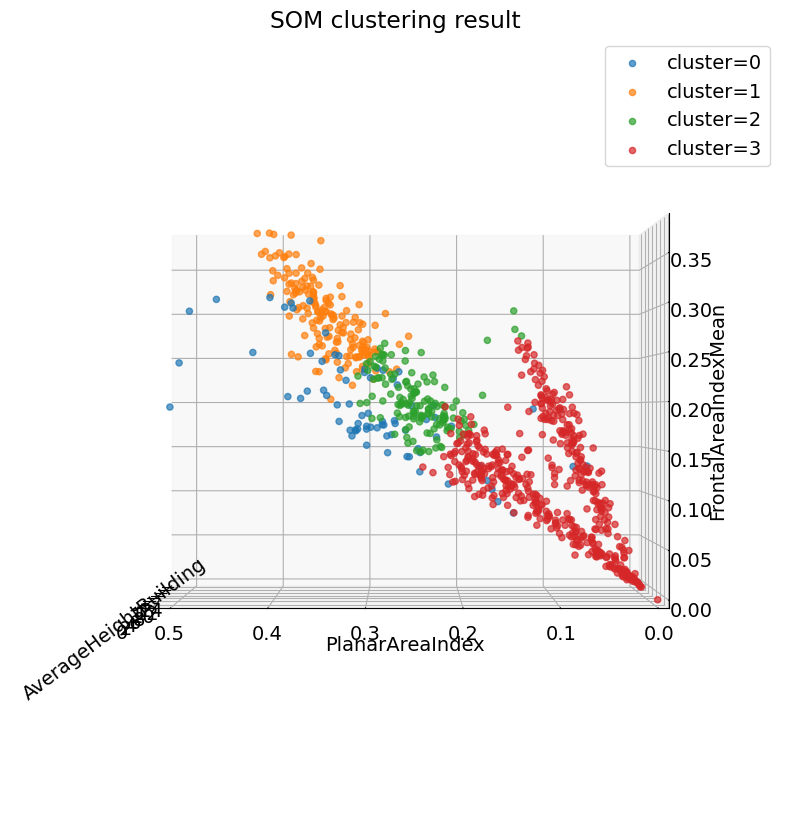

In [6]:
plot_columns = ["AverageHeightBuilding","PlanarAreaIndex","FrontalAreaIndexMean"]
som_plot(clustered_data, plot_columns, elevation=0, azimuth=180)

findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were foun

findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were foun

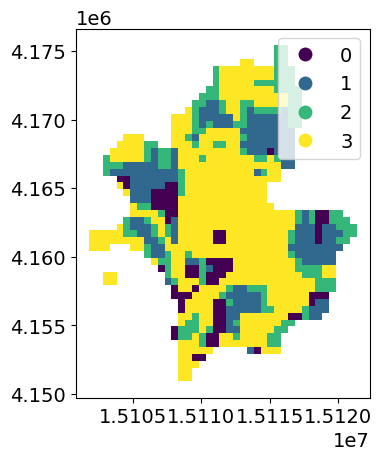

In [7]:
clustered_data.plot("cluster", legend=True, cmap="viridis", categories=[0, 1, 2,3])
plt.show()

findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were foun

IndexError: index 2 is out of bounds for axis 0 with size 2

findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were foun

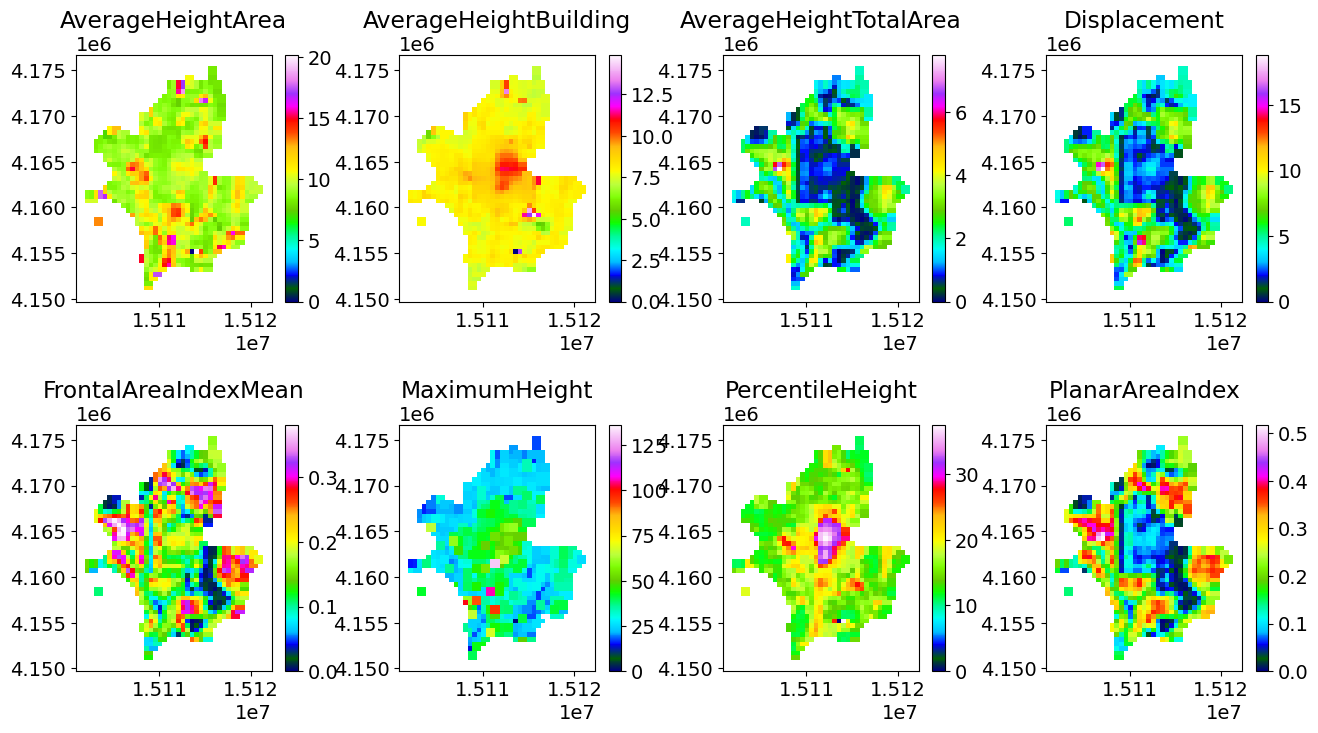

In [9]:
LA_ump = gpd.read_feather("/gucnas2/jiang/Japan/kyoto/kyoto_ULT_ump.feather")
# 创建一个 2x4 的子图布局
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5)

# 遍历除 'geometry' 列以外的所有列并绘制图像
columns_to_plot = LA_ump.columns.difference(['geometry', 'Percentile','FrontalAreaIndex', 'Rotation', 'RoughnessLength'])

for i, column in enumerate(columns_to_plot):
    row, col = divmod(i, 4)
    
    # 绘制当前列的图像
    LA_ump.plot(column=column, ax=axes[row, col], legend=True, cmap='gist_ncar')  # 使用适当的色彩图
    axes[row, col].set_title(column)

# 显示图像
plt.tight_layout()
plt.show()

### Nagoya FAI vs PAI

In [ ]:
data = gpd.read_feather("/gucnas2/jiang/nagoya/ULT_nagoya_ump.feather")
clustered_data = som_clustering(data, columns=["AverageHeightBuilding","PlanarAreaIndex","MaximumHeight","FrontalAreaIndexMean","StandardDeviation"])
som_plot(clustered_data, columns=["AverageHeightBuilding","PlanarAreaIndex","FrontalAreaIndexMean"], elevation=0, azimuth=180)

nagoya FAI vs PAI shows the same trend as tokyo

### Tiba FAI vs PAI

In [5]:
boundary = gpd.read_feather("/gucnas2/jiang/Japan/Tiba/tiba_grid.feather")
boundary.to_file("/gucnas2/jiang/Japan/Tiba/tiba_grid.shp")

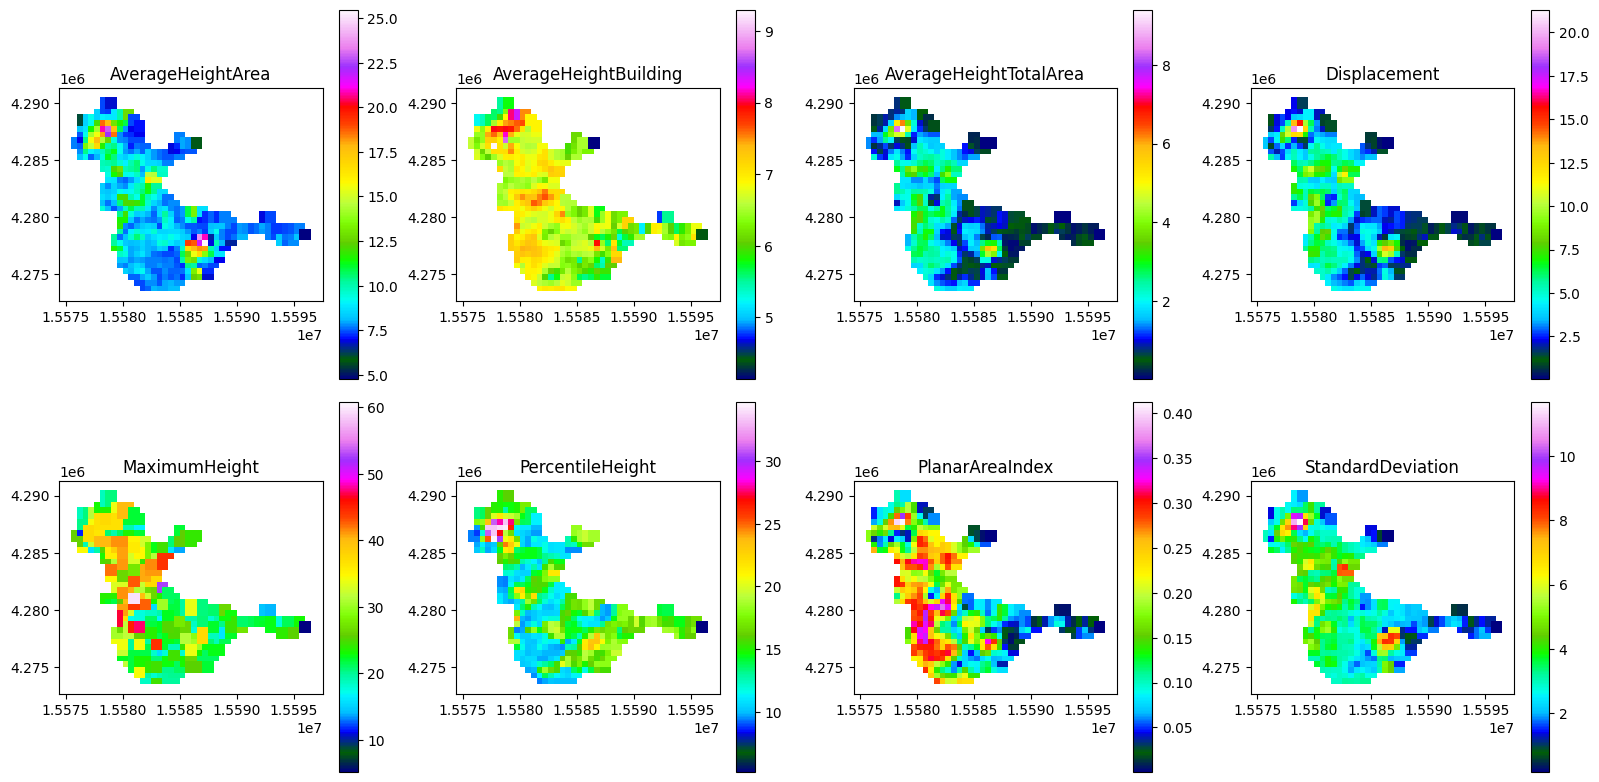

In [3]:
data = gpd.read_feather("/gucnas2/jiang/Japan/Tiba/tiba_ump.feather")
# 创建一个 2x4 的子图布局
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5)

# 遍历除 'geometry' 列以外的所有列并绘制图像
columns_to_plot = data.columns.difference(['geometry', 'Percentile','FrontalAreaIndex', 'Rotation', 'RoughnessLength'])

for i, column in enumerate(columns_to_plot):
    row, col = divmod(i, 4)
    
    # 绘制当前列的图像
    data.plot(column=column, ax=axes[row, col], legend=True, cmap='gist_ncar')  # 使用适当的色彩图
    axes[row, col].set_title(column)

# 显示图像
plt.tight_layout()
plt.show()

In [6]:
data['FrontalAreaIndexMean'] = data['FrontalAreaIndex'].apply(lambda x: np.mean(x))
data['RoughnessLengthMean'] = data['RoughnessLength'].apply(lambda x: np.mean(x))
data.to_feather("/gucnas2/jiang/Japan/Tiba/tiba_ULT_ump.feather")

findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were foun

findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were foun

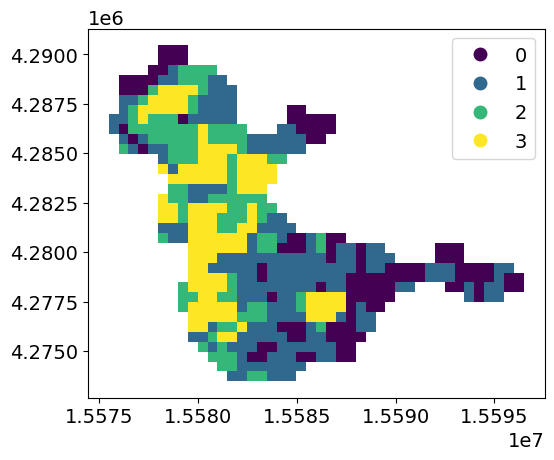

In [15]:
clustered_data.plot("cluster", legend=True, cmap="viridis", categories=[0, 1, 2, 3])
plt.show()

/home/jiang/.conda/envs/remote/lib/python3.10/site-packages/minisom.py:162: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')
/home/jiang/.conda/envs/remote/lib/python3.10/site-packages/minisom.py:379: UserWarning: PCA initialization inappropriate:One of the dimensions of the map is 1.
  warn(msg)
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont

findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were foun

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.4908957068688213


findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were foun

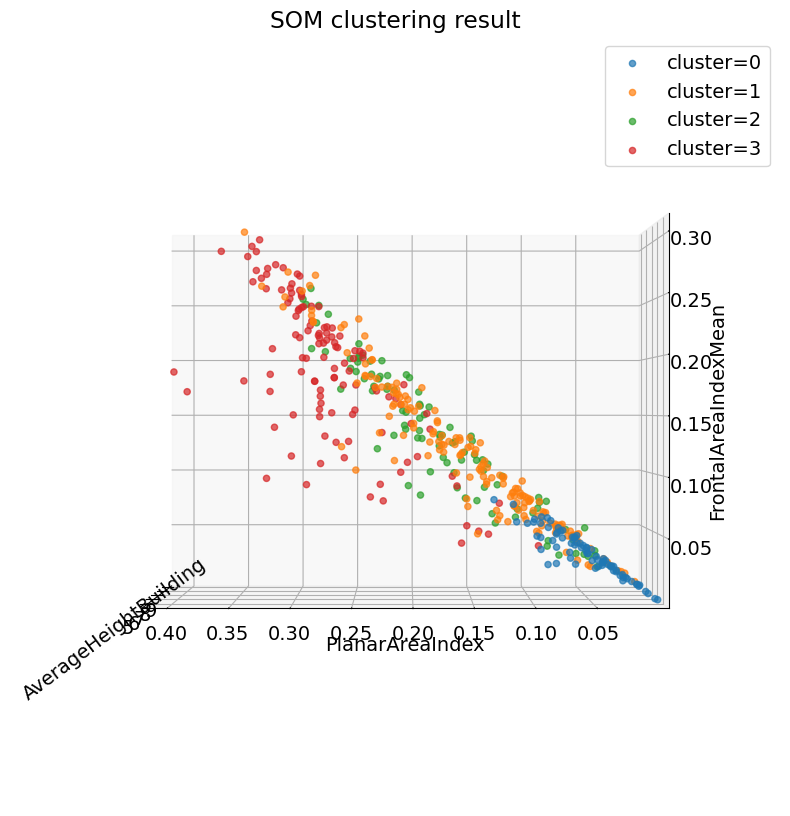

In [14]:
data = gpd.read_feather("/gucnas2/jiang/Japan/Tiba/tiba_ULT_ump.feather")
clustered_data = som_clustering(data, columns=["AverageHeightBuilding","PlanarAreaIndex","MaximumHeight","FrontalAreaIndexMean","StandardDeviation"])
som_plot(clustered_data, columns=["AverageHeightBuilding","PlanarAreaIndex","FrontalAreaIndexMean"], elevation=0, azimuth=180)

### Sacramento FAI vs PAI

In [12]:
data = gpd.read_feather("/gucnas2/jiang/USA/California/Scramento/Scramento_ULT_ump.feather")
clustered_data = som_clustering(data, columns=["AverageHeightBuilding","PlanarAreaIndex","MaximumHeight","FrontalAreaIndexMean","StandardDeviation"])
columns = ["AverageHeightBuilding","PlanarAreaIndex","FrontalAreaIndexMean"]
#som_plot(clustered_data, columns, elevation=0, azimuth=180)
clustered_data.to_feather("/gucnas2/jiang/USA/California/Scramento/clustered_ump.feather")

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.2434834546468336


/home/jiang/.conda/envs/remote/lib/python3.10/site-packages/minisom.py:162: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')
/home/jiang/.conda/envs/remote/lib/python3.10/site-packages/minisom.py:379: UserWarning: PCA initialization inappropriate:One of the dimensions of the map is 1.
  warn(msg)


### Overlay tokyo and Sacramento

In [13]:
data1 = gpd.read_feather("/gucnas2/jiang/USA/California/Scramento/Scramento_ULT_ump.feather")
data2 = gpd.read_feather("/gucnas2/jiang/Tokyo_shp/Y_UMP/som_test.feather")

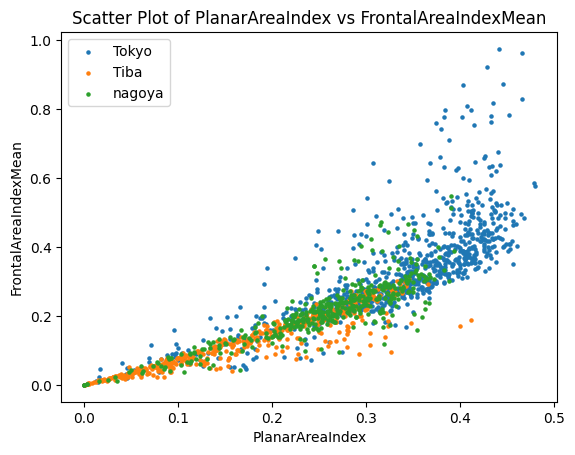

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 读取数据
data1 = gpd.read_feather("/gucnas2/jiang/USA/California/Scramento/Scramento_ULT_ump.feather")
data2 = gpd.read_feather("/gucnas2/jiang/Tokyo_shp/Y_UMP/som_test.feather")
data3 = gpd.read_feather("/gucnas2/jiang/Japan/Tiba/clustered_ump.feather")
data4 = gpd.read_feather("/gucnas2/jiang/nagoya/som_test.feather")

# 创建散点图
#plt.scatter(data1["PlanarAreaIndex"], data1["FrontalAreaIndexMean"], label="Sacramento",s = 5)
plt.scatter(data2["PlanarAreaIndex"], data2["FrontalAreaIndexMean"], label="Tokyo",s = 5)
plt.scatter(data3["PlanarAreaIndex"], data3["FrontalAreaIndexMean"], label="Tiba",s = 5)
plt.scatter(data4["PlanarAreaIndex"], data4["FrontalAreaIndexMean"], label="nagoya",s = 5)

# 添加标签和标题
plt.xlabel("PlanarAreaIndex")
plt.ylabel("FrontalAreaIndexMean")
plt.title("Scatter Plot of PlanarAreaIndex vs FrontalAreaIndexMean")

# 添加图例
plt.legend()

# 显示图形
plt.show()


findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were foun

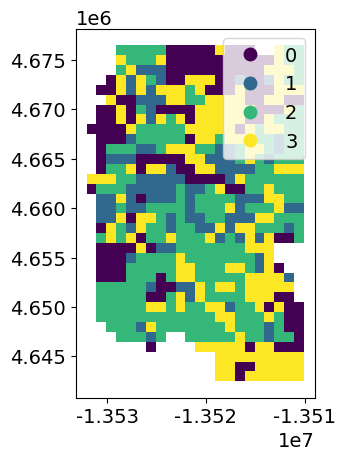

In [11]:
clustered_data.plot("cluster", legend=True, cmap="viridis", categories=[0, 1, 2, 3])
plt.show()